Do a community finding on the movie network; use the Fast Greedy Newman
algorithm. Tag each community with the genres that appear in 20% or more of
the movies in the community. Are these tags meaningful?

In [3]:
library(data.table)
library(igraph)

Warning message:
“package ‘data.table’ was built under R version 3.3.2”


This data.table install has not detected OpenMP support. It will work but slower in single threaded mode.




Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



# Read graph from dataframe

In [3]:
gframe = fread(file="movie_network.txt")

Read 55035189 rows and 3 (of 3) columns from 3.039 GB file in 00:00:46


In [4]:
colnames(gframe) = c("node1", "node2", "weight")

In [5]:
g = simplify( graph.data.frame(gframe, directed=FALSE) )

In [6]:
names = V(g)$name

In [7]:
# Number of vertices
vcount(g)

[1] 50833

In [8]:
# Number of edges
ecount(g)

[1] 27492178

# Read genre list as dataframe and set movie name to be the index

In [9]:
genres = fread(file="genres.txt", header=FALSE)

In [10]:
setkey(genres, V1)

In [11]:
V(g)$genre = genres[names, ]$V2

# Community Detection

This task takes way too long, unless I somehow reduce the graph size. I used metis, more specifically, gpmetis, to cut the graphs into 5 smaller graphs, while minimizing edge cut weights. 

In [25]:
V(g)$comm.id = rep(-1, vcount(g))

## METIS FTW

In [37]:
# parts = fread(file="metis/graph.txt.part.3")$V1
# cum_com = 0
# for(i in unique(parts)){
#     pi = which(parts == i)
#     gi = induced_subgraph(g, pi)
#     comms = cluster_fast_greedy(gi, weights = E(gi)$weight)
    
#     V(g)$comm.id[pi] = comms$membership + cum_com
    
#     cum_com = cum_com + length( unique( comms$membership ) )
# }
# table(V(g)$comm.id)
# V(g)$comm.desc = rep(NA, vcount(g))

# for(x in unique(V(g)$comm.id)){
#     vs = which(V(g)$comm.id == x)
#     genres = V(g)$genre[vs]
#     ugenres = unique(genres)
#     frequency = table(genres)
#     gthan = ugenres[ sapply(ugenres, function(x){ frequency[x] / sum(frequency) > 0.15 }) ]
#     desc = do.call(paste, c(as.list(gthan), sep=",", collapse=""))
#     V(g)$comm.desc[vs] = rep(desc, length( vs ))
# }
## Save this graph for later
# saveRDS(g, "rfiles/g.rds")

# Full graph community detection. #YOLO

In [1]:
g = readRDS("rfiles/g.rds")

In [4]:
if(file.exists("rfiles/comm.rds")){
    comms = readRDS("rfiles/comm.rds")
}
else{
    comms = cluster_fast_greedy(g, weights = E(g)$weight)
    saveRDS(comms, "rfiles/comm.rds")
}

In [6]:
V(g)$comm.id = comms$membership

In [7]:
table(V(g)$comm.id)


    1     2     3     4     5     6     7     8     9    10    11    12 
 1683  7598  5085   980  7919  3000  2550  1549  1859  3600   594 14416 

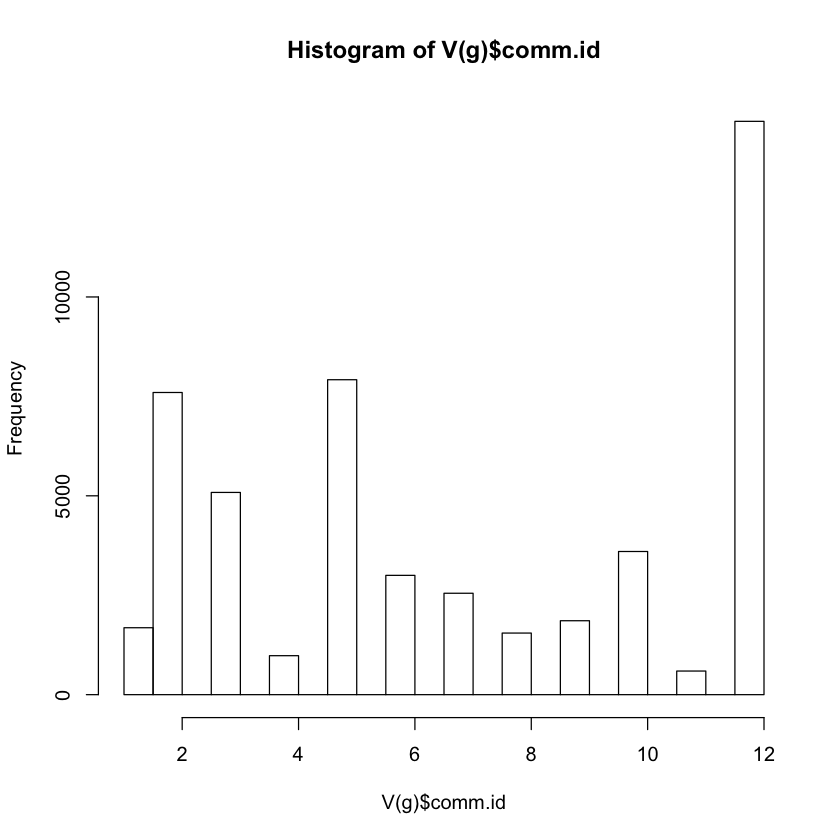

In [5]:
hist(V(g)$comm.id)

In [45]:
V(g)$comm.desc = rep(NA, vcount(g))

for(x in unique(V(g)$comm.id)){
    vs = which(V(g)$comm.id == x)
    genres = V(g)$genre[vs]
    ugenres = unique(genres)
    frequency = table(genres)
    gthan = ugenres[ sapply(ugenres, function(x){ frequency[x] / sum(frequency) > 0.18}) ]
    desc = do.call(paste, c(as.list(gthan), sep=",", collapse=""))
    V(g)$comm.desc[vs] = rep(desc, length( vs ))
}

In [47]:
# Save this graph for later
saveRDS(g, "rfiles/g.rds")